In [ ]:
run_project = input("Czy chcesz uruchomić projekt? (tak/nie): ").lower()

if run_project != 'tak':
    raise SystemExit("Projekt nie zostanie uruchomiony.")
print("Projekt uruchomiony.")

## Biblioteki

In [ ]:
from pathlib import Path
import os
import re
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import loguniform, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    KBinsDiscretizer,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_validate,
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)
from IPython.display import display
import joblib
import kagglehub
from sklearn.decomposition import PCA


## EDA

 Załadowano 768 wierszy i 9 kolumn.



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Statystyki opisowe:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00



Rozkład klas:


,count
Outcome,
Brak cukrzycy,500
Cukrzyca,268


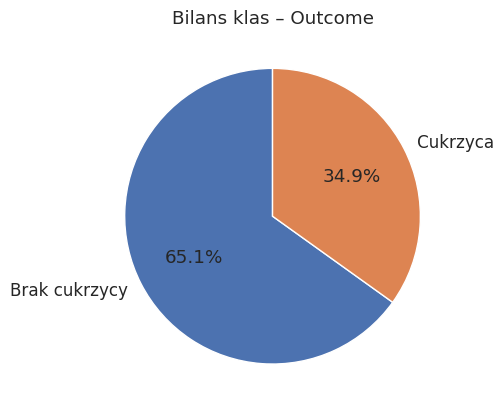


Wartości 0 (traktowane jako braki):


,Liczba zer
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


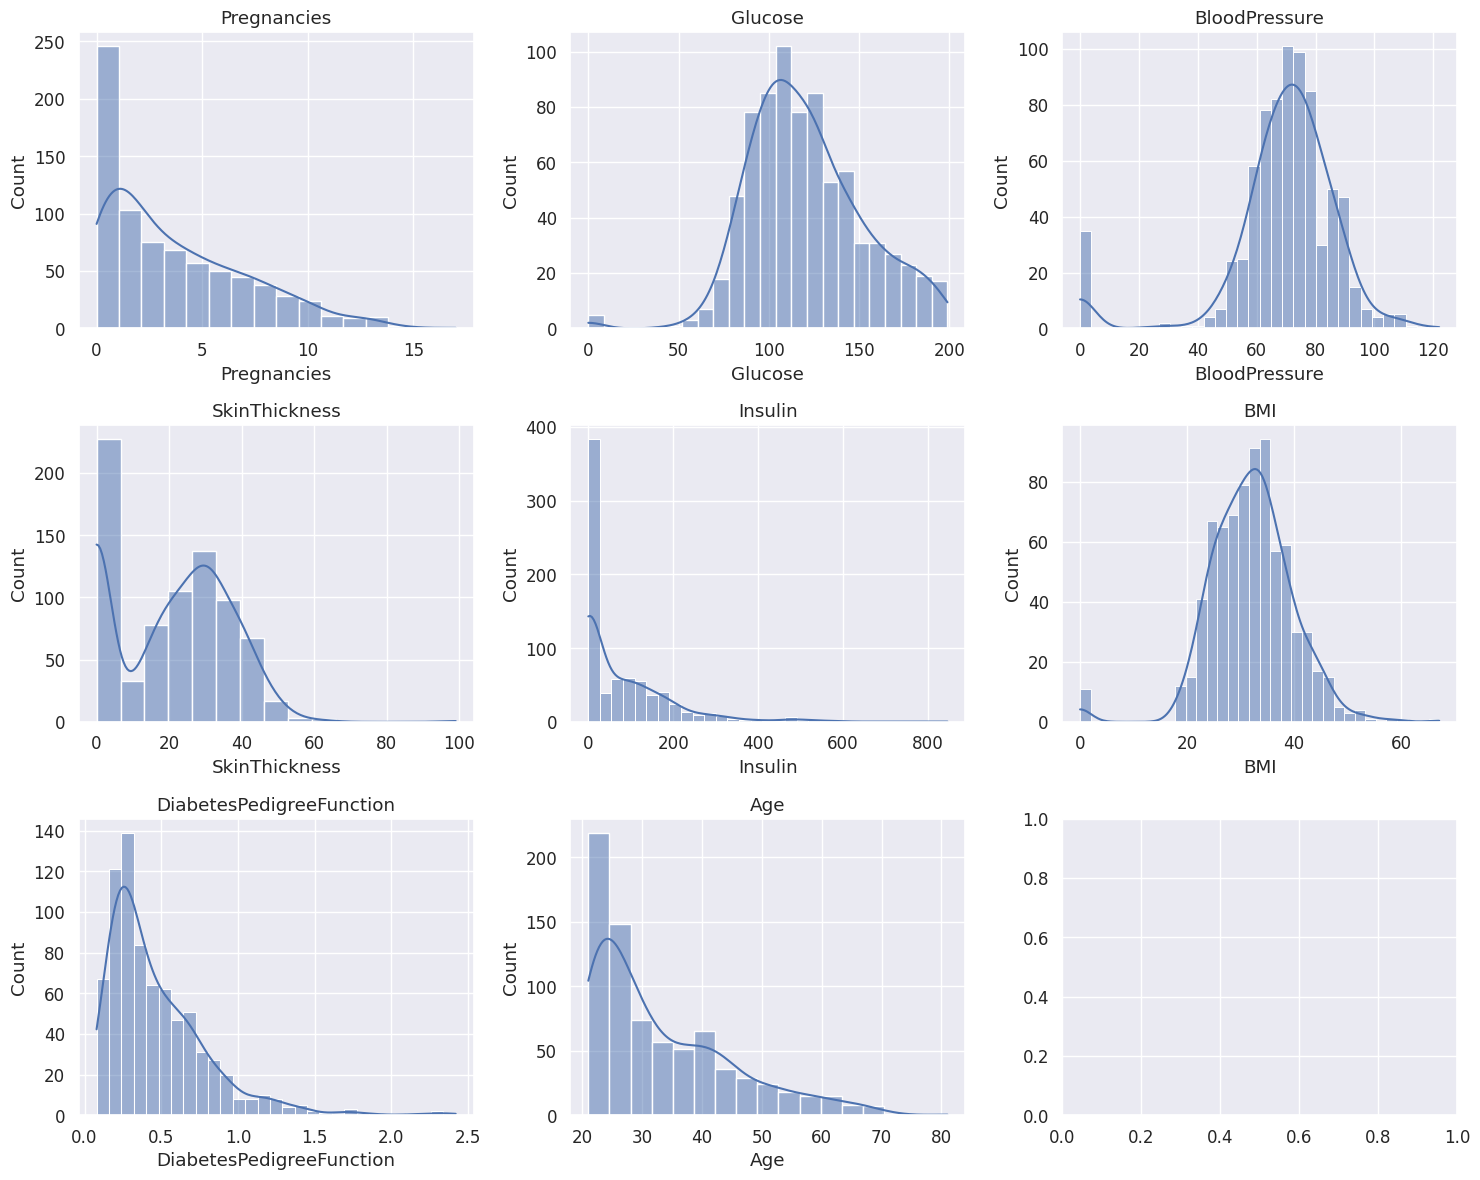

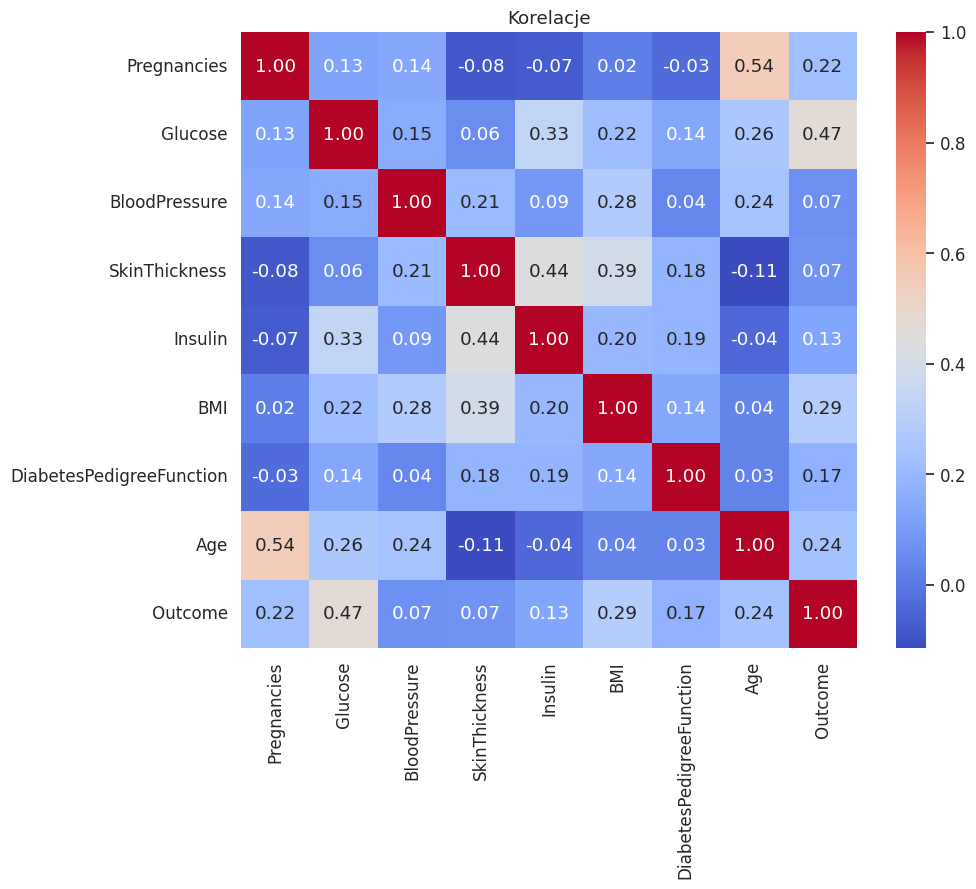

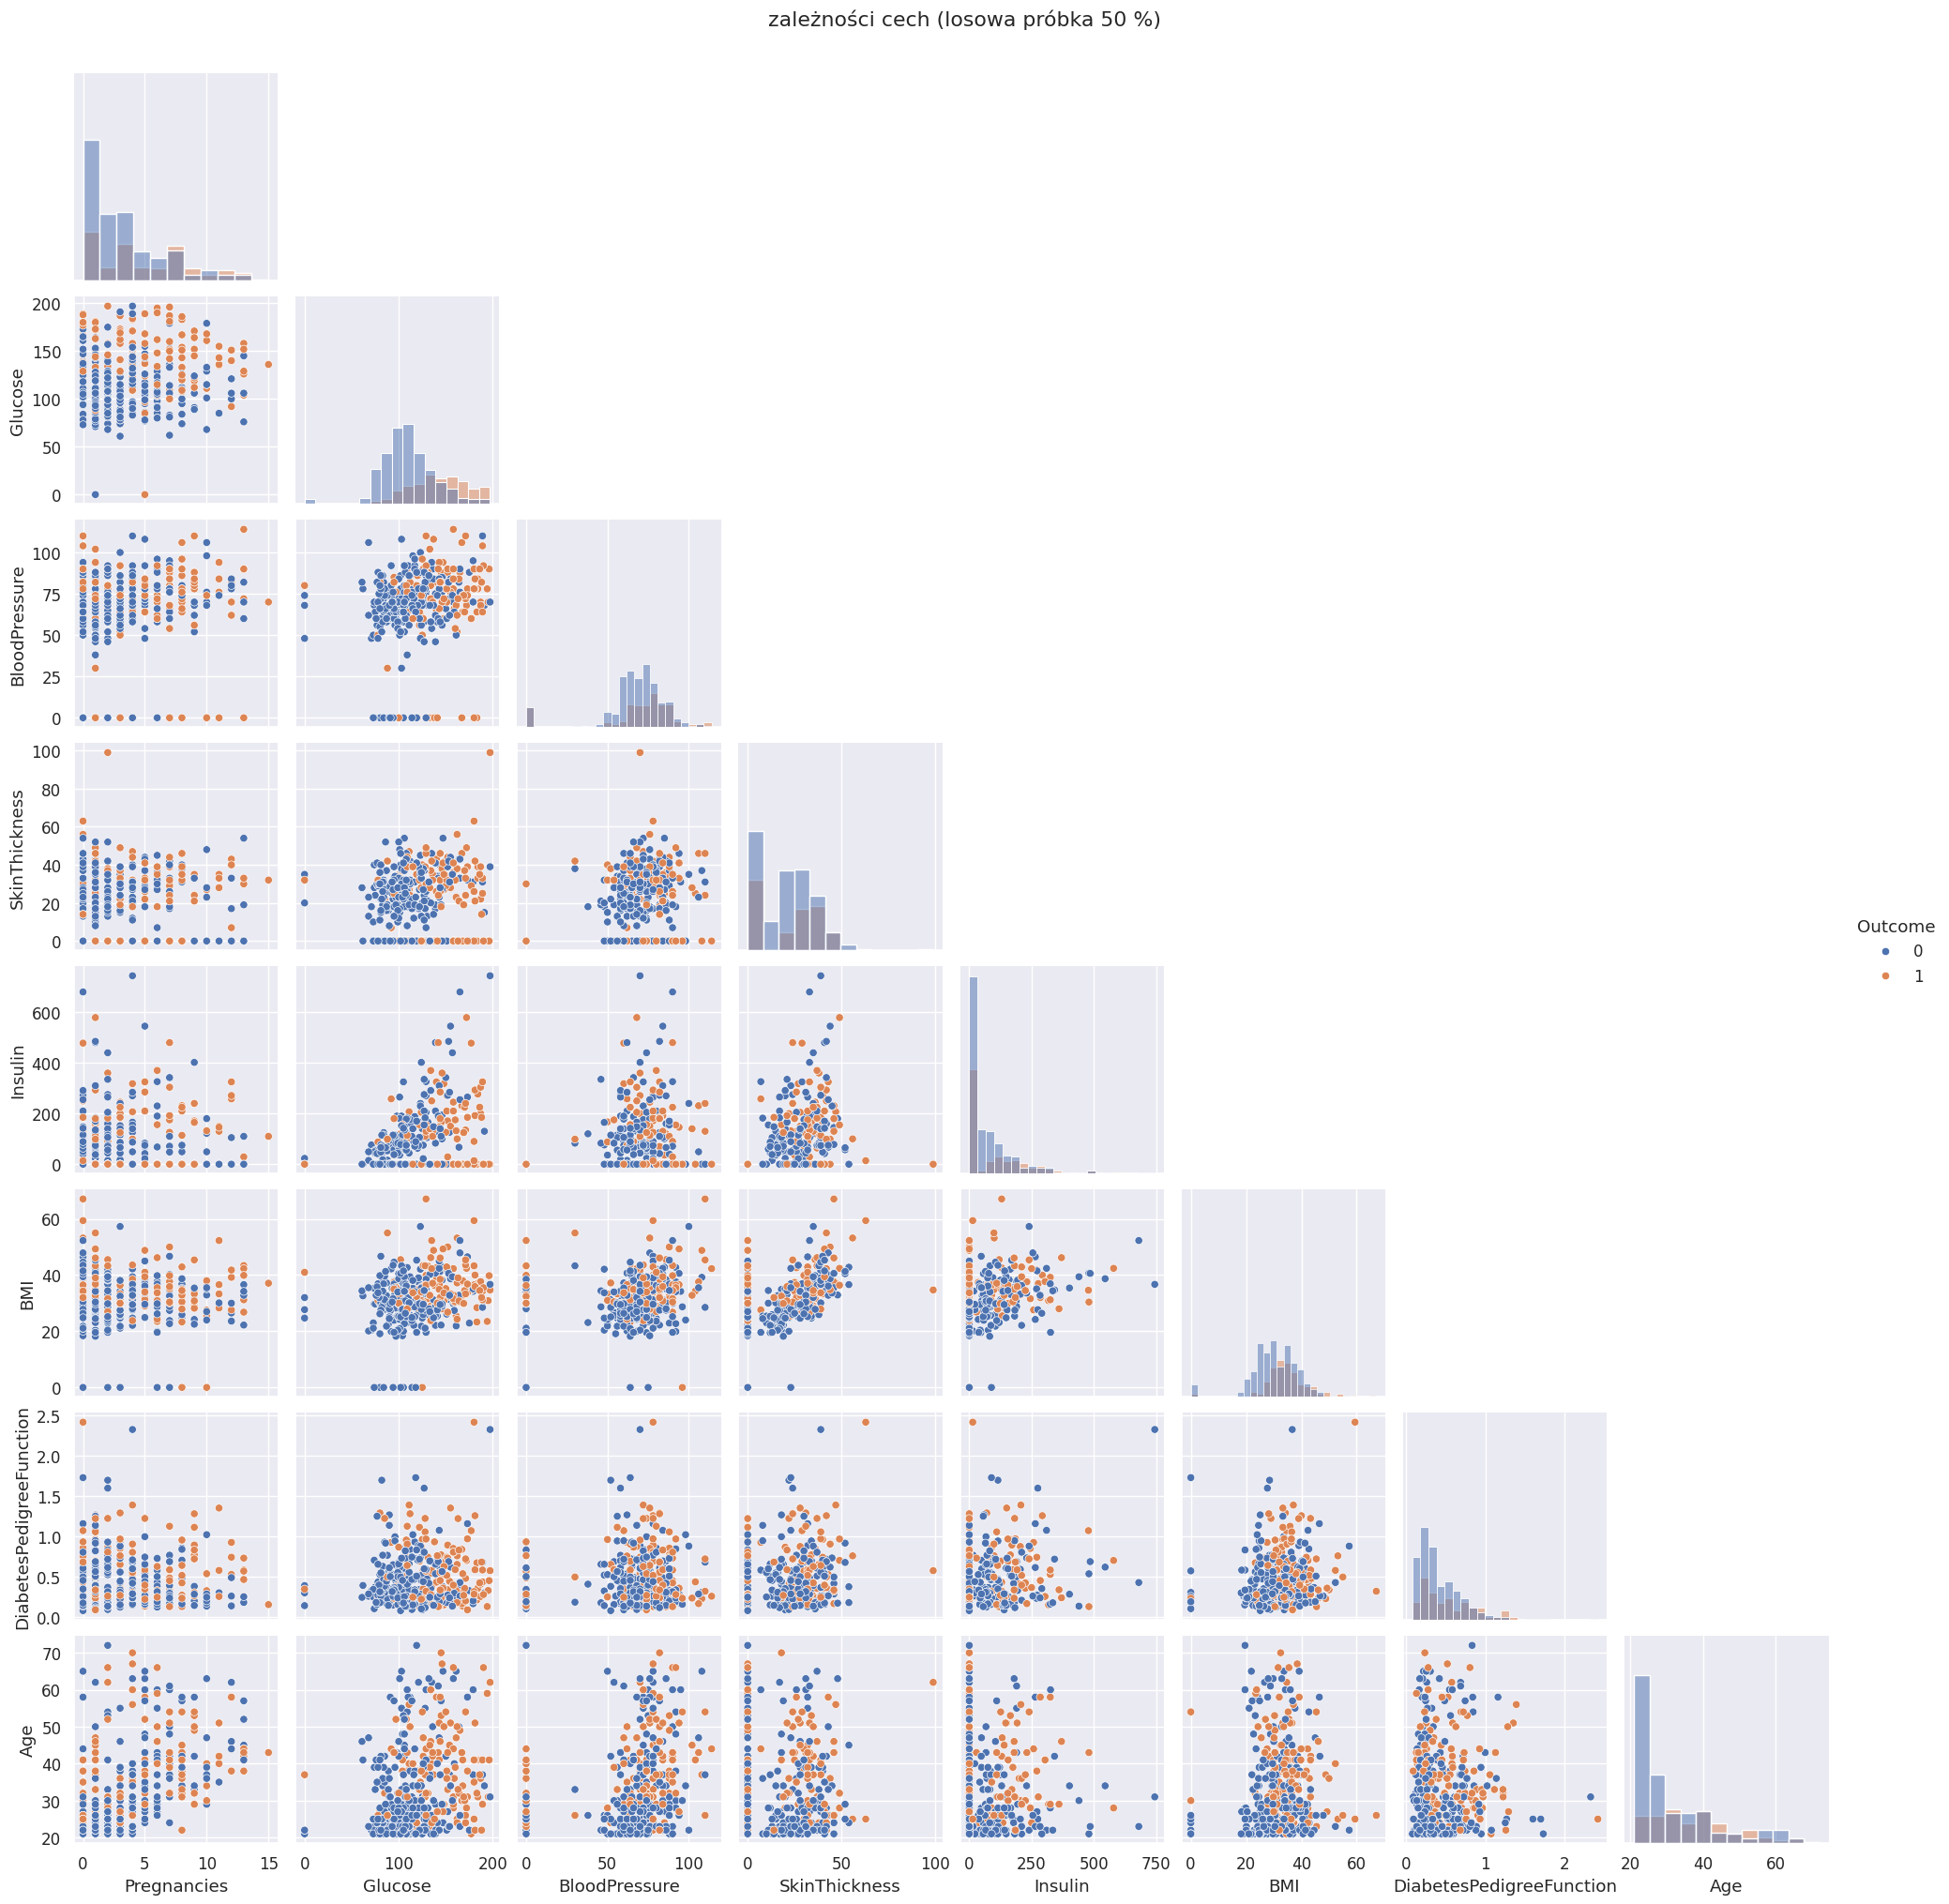

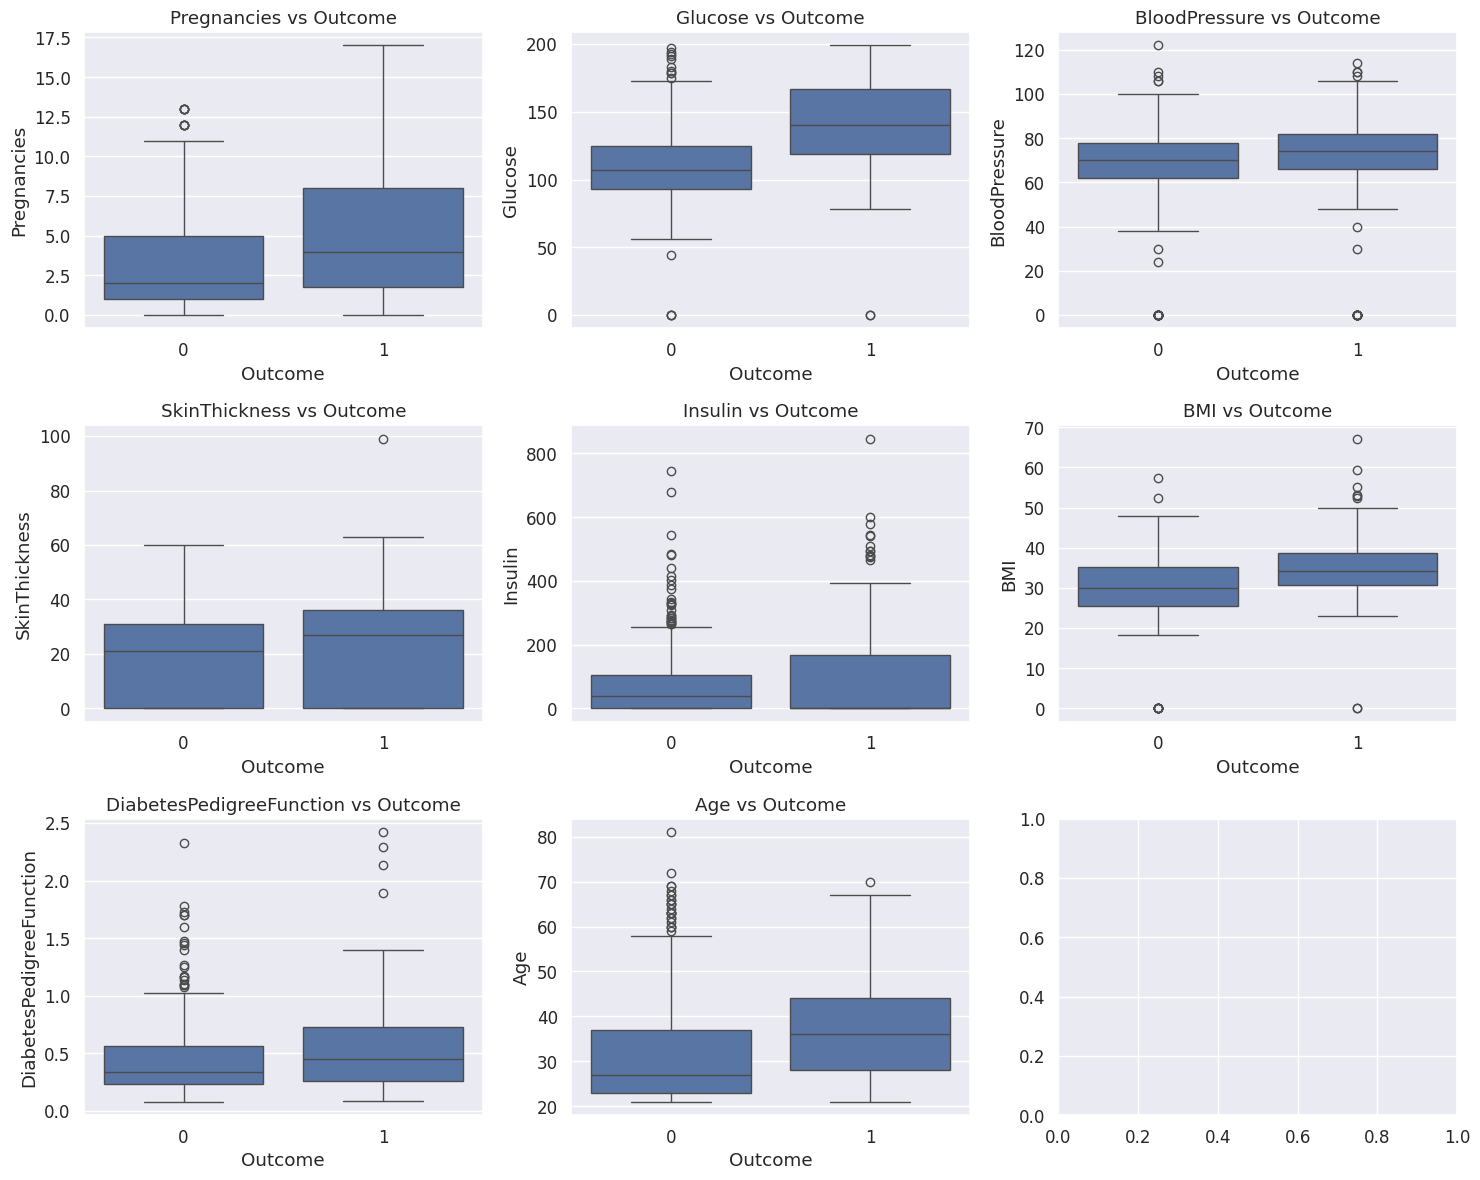

In [ ]:
plt.style.use("default")  # ustawienie domyślnego stylu wykresów
sns.set(font_scale=1.1)  # zwiększenie skali czcionki na wykresach
pd.set_option("display.max_columns", None)  # wyświetlanie wszystkich kolumn

path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")  # pobranie zbioru danych
path = pathlib.Path(path)  # konwersja ścieżki na obiekt Path
csv_path = (path / "diabetes.csv").as_posix()  # ścieżka do pliku CSV

df = pd.read_csv(csv_path)  # wczytanie danych do DataFrame
print(f" Załadowano {df.shape[0]} wierszy i {df.shape[1]} kolumn.\n")  # podsumowanie rozmiaru danych
display(df.head())  # podgląd pierwszych wierszy
df.info()  # informacje o strukturze DataFrame
print("\nStatystyki opisowe:")  # nagłówek do statystyk
display(df.describe().T)  # wyświetlenie statystyk opisowych

class_counts = df["Outcome"].value_counts().rename(index={0:"Brak cukrzycy",1:"Cukrzyca"})  # zliczenie klas
print("\nRozkład klas:")  # nagłówek rozkładu klas
display(class_counts)  # wyświetlenie rozkładu klas

fig, ax = plt.subplots()  # inicjalizacja wykresu
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)  # wykres kołowy klas
ax.set_title("Bilans klas – Outcome")  # tytuł wykresu
plt.show()  # wyświetlenie wykresu

zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]  # kolumny traktowane 0 jako brak
zero_summary = (df[zero_cols] == 0).sum().to_frame("Liczba zer")  # policzenie wystąpień zera
print("\nWartości 0 (traktowane jako braki):")  # nagłówek do podsumowania zer
display(zero_summary)  # wyświetlenie podsumowania

num_cols = df.columns.drop("Outcome")  # lista cech numerycznych
fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka wykresów
axes = axes.flat  # spłaszczenie tablicy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.histplot(df[col], kde=True, ax=axes[i])  # histogram z estymacją gęstości
    axes[i].set_title(col)  # tytuł wykresu
for ax in axes[len(num_cols):]:  # wyłączenie pustych osi, jeśli cech nie dzieli się równomiernie na 3
    ax.axis("off")
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wszystkich histogramów

corr = df.corr(numeric_only=True)  # macierz korelacji cech numerycznych
plt.figure(figsize=(10, 8))  # rozmiar mapy cieplnej
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)  # mapa cieplna korelacji
plt.title("Korelacje")  # tytuł mapy
plt.show()  # wyświetlenie mapy korelacji

sns.pairplot(df.sample(frac=0.5, random_state=42), hue="Outcome",
             vars=num_cols, diag_kind="hist", corner=True)  # analiza par cech na próbce 50%
plt.suptitle("zależności cech (losowa próbka 50 %)", y=1.02)  # zbiorczy tytuł pairplot
plt.show()  # wyświetlenie pairplot

fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka wykresów pudełkowych
axes = axes.flat  # spłaszczenie tablicy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.boxplot(x="Outcome", y=col, data=df, ax=axes[i])  # wykres pudełkowy cechy względem etykiety
    axes[i].set_title(f"{col} vs Outcome")  # tytuł wykresu
for ax in axes[len(num_cols):]:  # wyłączenie pustych osi
    ax.axis("off")
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów pudełkowych


## Preprocessing

In [ ]:
target = "Outcome"  # zmienna celu
feature_cols    = df.columns.drop(target).tolist()  # lista cech
zero_mask_cols  = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]  # kolumny maskowane zerami

X = df[feature_cols].copy()  # dane wejściowe
y = df[target].copy()  # etykiety

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # procent testu
    stratify=y,  # stratifikacja
    random_state=42  # ziarno losowości
)

class ZeroToNaN(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols  # kolumny do konwersji
    def fit(self, X, y=None):
        return self  # brak dopasowania
    def transform(self, X):
        X = X.copy()  # kopia danych
        X[self.cols] = X[self.cols].replace(0, np.nan)  # zamiana zer na NaN
        return X  # zwrócenie przetworzonych danych

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q=0.01, upper_q=0.99):
        self.lower_q = lower_q  # dolny kwantyl
        self.upper_q = upper_q  # górny kwantyl
    def fit(self, X, y=None):
        arr = X if isinstance(X, np.ndarray) else X.to_numpy()  # konwersja na tablicę
        q_low  = np.nanquantile(arr, self.lower_q, axis=0)  # obliczenie dolnego kwantyla
        q_high = np.nanquantile(arr, self.upper_q, axis=0)  # obliczenie górnego kwantyla
        self.bounds_ = np.vstack([q_low, q_high]).T  # utworzenie progów
        return self  # zwrócenie instancji
    def transform(self, X):
        arr = X if isinstance(X, np.ndarray) else X.to_numpy()  # konwersja na tablicę
        for i in range(arr.shape[1]):  # iteracja po kolumnach
            lo, hi = self.bounds_[i]  # zakres przycinania
            arr[:, i] = np.clip(arr[:, i], lo, hi)  # przycięcie wartości
        return arr  # zwrócenie przyciętych danych

numeric_pipeline_rf = Pipeline([
    ("zero_to_nan", ZeroToNaN(zero_mask_cols)),  # konwersja zer
    ("imputer",     SimpleImputer(strategy="median", add_indicator=True)),  # imputacja medianą + wskaźnik braków
    ("winsor",      Winsorizer(0.01, 0.99)),  # winsoryzacja
    ("binning",     KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="quantile")),  # dyskretyzacja
])

preprocessor_rf = ColumnTransformer([
    ("num", numeric_pipeline_rf, feature_cols)  # przetwarzanie cech numerycznych
], remainder="drop")  # odrzucenie pozostałych

X_train_rf_proc = preprocessor_rf.fit_transform(X_train)  # dopasowanie i przetwarzanie treningu
X_test_rf_proc  = preprocessor_rf.transform(X_test)  # przetwarzanie testu

print(f"Po preprocessingu: X_train={X_train_rf_proc.shape}, X_test={X_test_rf_proc.shape}")  # podsumowanie rozmiarów


Po preprocessingu pod RF: X_train=(614, 43), X_test=(154, 43)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 8 is constant and will be replaced with 0.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 9 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) 

## EDA po preprocessingu

Przetworzone kolumny: 43


,Pregnancies_bin0,Pregnancies_bin1,Pregnancies_bin2,Pregnancies_bin3,Pregnancies_bin4,Glucose_bin0,Glucose_bin1,Glucose_bin2,Glucose_bin3,Glucose_bin4,BloodPressure_bin0,BloodPressure_bin1,BloodPressure_bin2,BloodPressure_bin3,BloodPressure_bin4,SkinThickness_bin0,SkinThickness_bin1,SkinThickness_bin2,SkinThickness_bin3,Insulin_bin0,Insulin_bin1,Insulin_bin2,Insulin_bin3,BMI_bin0,BMI_bin1,BMI_bin2,BMI_bin3,BMI_bin4,DiabetesPedigreeFunction_bin0,DiabetesPedigreeFunction_bin1,DiabetesPedigreeFunction_bin2,DiabetesPedigreeFunction_bin3,DiabetesPedigreeFunction_bin4,Age_bin0,Age_bin1,Age_bin2,Age_bin3,Age_bin4,Glucose_missing,BloodPressure_missing,SkinThickness_missing,Insulin_missing,BMI_missing
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


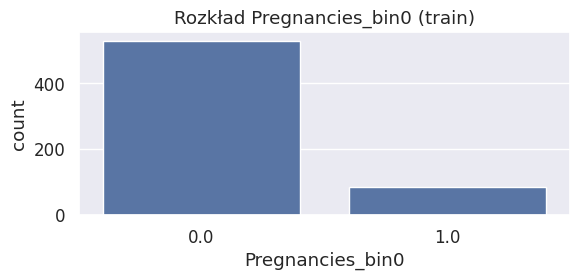

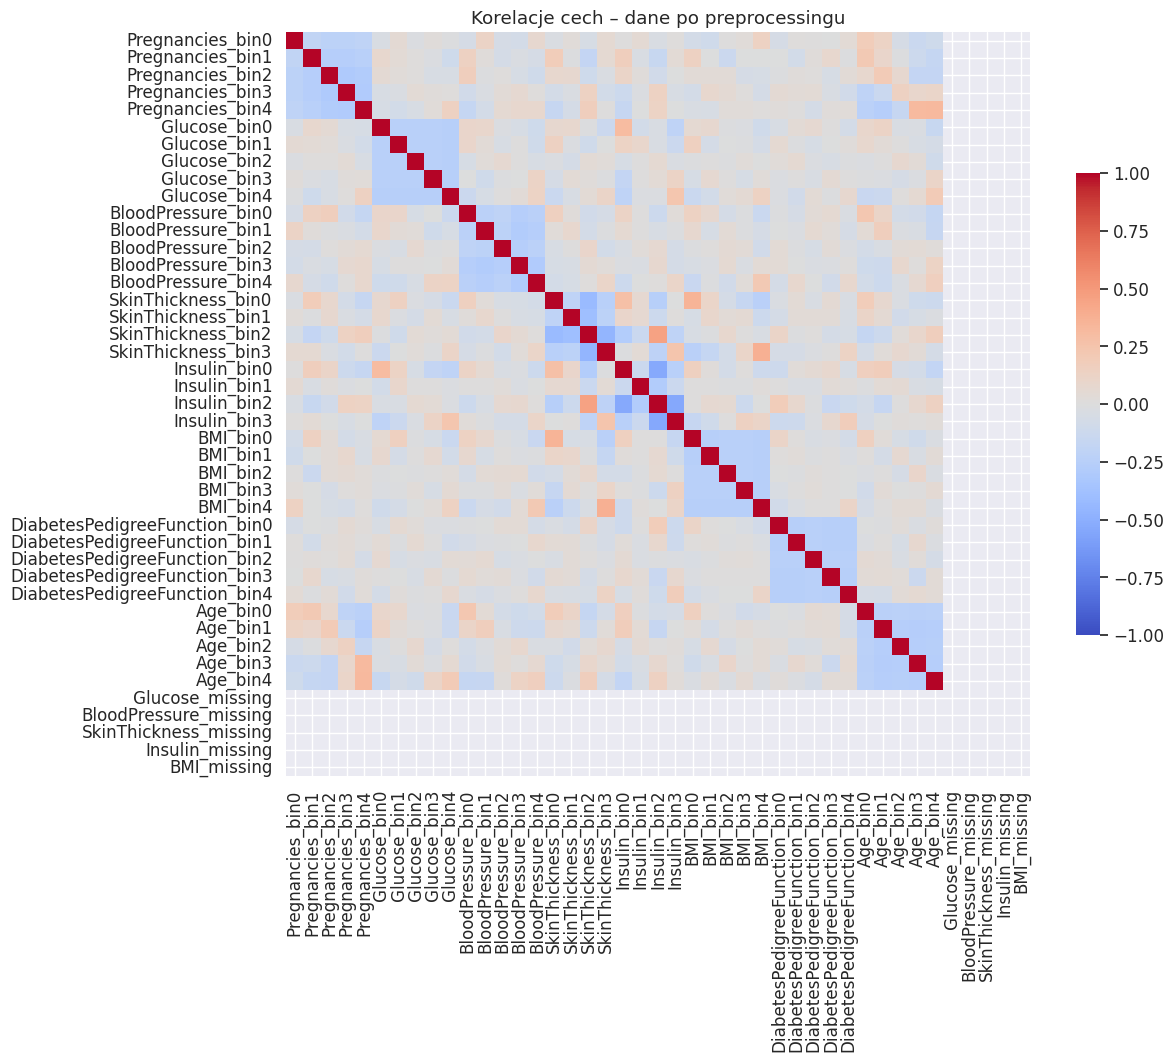

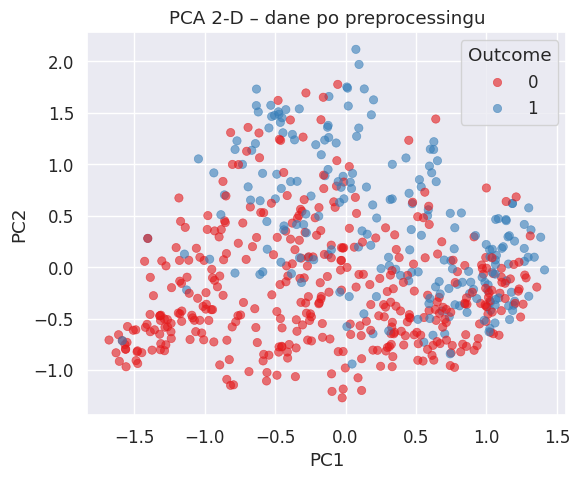

Bilans klas w zbiorze train po preprocessingu:


,count
Outcome,
Brak cukrzycy,400
Cukrzyca,214


In [ ]:
binning      = preprocessor_rf.named_transformers_["num"]["binning"]  # binowanie
n_bins       = [len(edges) - 1 for edges in binning.bin_edges_]  # liczba przedziałów
feat_binned  = [f"{col}_bin{idx}"
                for col, nb in zip(feature_cols, n_bins)
                for idx in range(nb)]  # nazwy cech po binowaniu
missing_idx  = preprocessor_rf.named_transformers_["num"]["imputer"].indicator_.features_  # indeksy braków
feat_missing = [f"{feature_cols[i]}_missing" for i in missing_idx]  # nazwy wskaźników braków
proc_cols    = feat_binned + feat_missing  # lista przetworzonych kolumn

X_train_rf_df = pd.DataFrame(X_train_rf_proc, columns=proc_cols)  # DataFrame train po RF
X_test_rf_df  = pd.DataFrame(X_test_rf_proc,  columns=proc_cols)  # DataFrame test po RF

print("Przetworzone kolumny:", len(proc_cols))  # liczba kolumn po preprocessingu
display(X_train_rf_df.head())  # podgląd danych

sample_feat = feat_binned[0]  # przykładowa cecha binned
plt.figure(figsize=(6, 3))  # rozmiar wykresu
sns.countplot(x=sample_feat, data=X_train_rf_df)  # wykres liczebności
plt.title(f"Rozkład {sample_feat} (train)")  # tytuł wykresu
plt.tight_layout()  # układ wykresu
plt.show()  # wyświetlenie wykresu

corr_proc = X_train_rf_df.corr(method="pearson")  # macierz korelacji
plt.figure(figsize=(12, 10))  # rozmiar mapy cieplnej
sns.heatmap(corr_proc, cmap="coolwarm", center=0, square=True,
            cbar_kws={"shrink": .6}, vmax=1, vmin=-1)  # mapa cieplna korelacji
plt.title("Korelacje cech – dane po preprocessingu")  # tytuł mapy
plt.show()  # wyświetlenie mapy

pca = PCA(n_components=2, random_state=42)  # analiza głównych składowych
proj = pca.fit_transform(X_train_rf_df)  # projekcja danych
plt.figure(figsize=(6, 5))  # rozmiar wykresu PCA
sns.scatterplot(x=proj[:, 0], y=proj[:, 1],
                hue=y_train.reset_index(drop=True),
                palette="Set1", alpha=.6, edgecolor=None)  # wykres punktowy PCA
plt.title("PCA 2-D – dane po preprocessingu")  # tytuł wykresu
plt.xlabel("PC1"); plt.ylabel("PC2")  # etykiety osi
plt.legend(title="Outcome")  # legenda
plt.tight_layout()  # układ wykresu
plt.show()  # wyświetlenie wykresu

print("Bilans klas w zbiorze train po preprocessingu:")  # nagłówek bilansu klas
display(y_train.value_counts().rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"}))  # rozkład


## Hipermapametry i trening

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog modeli
models_dir.mkdir(parents=True, exist_ok=True)  # utworzenie katalogu

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # walidacja krzyżowa

#  Model prosty – strojenie tylko liczby drzew
rf_simple = RandomForestClassifier(random_state=42, n_jobs=-1)  # inicjalizacja RF
param_simple = {  # zakres parametrów
    "n_estimators": [50, 100, 200]  # liczba drzew
}
search_simple = RandomizedSearchCV(
    rf_simple,
    param_simple,
    n_iter=3,  # liczba prób
    scoring="roc_auc",  # metryka AUC
    cv=cv,  # przekazanie CV
    random_state=42,
    n_jobs=-1
)
search_simple.fit(X_train_rf_proc, y_train)  # dopasowanie modelu
joblib.dump(search_simple.best_estimator_, models_dir / "rf_simple.joblib")  # zapis modelu

#  Model umiarkowany – dodatkowe ograniczenie głębokości
rf_mid = RandomForestClassifier(random_state=42, n_jobs=-1)  # inicjalizacja RF
param_mid = {  # zakres parametrów
    "n_estimators":    [100, 200, 300],  # liczba drzew
    "max_depth":       [None, 10, 20, 30]  # maksymalna głębokość
}
search_mid = RandomizedSearchCV(
    rf_mid,
    param_mid,
    n_iter=8,  # liczba prób
    scoring="roc_auc",  # metryka AUC
    cv=cv,  # przekazanie CV
    random_state=42,
    n_jobs=-1
)
search_mid.fit(X_train_rf_proc, y_train)  # dopasowanie modelu
joblib.dump(search_mid.best_estimator_, models_dir / "rf_mid.joblib")  # zapis modelu

#  Model zaawansowany – strojenie wielu parametrów
rf_adv = RandomForestClassifier(random_state=42, n_jobs=-1)  # inicjalizacja RF
param_adv = {  # zakres parametrów
    "n_estimators":    [100, 200, 300, 500],  # liczba drzew
    "max_depth":       [None, 5, 10, 20, 30],  # maksymalna głębokość
    "max_features":    ["sqrt", "log2", None],  # liczba cech do podziału
    "min_samples_split":[2, 5, 10],  # minimalne próbki do podziału
    "min_samples_leaf": [1, 2, 4],  # minimalne próbki w liściu
    "bootstrap":       [True, False]  # bootstrap
}
search_adv = RandomizedSearchCV(
    rf_adv,
    param_adv,
    n_iter=20,  # liczba prób
    scoring="roc_auc",  # metryka AUC
    cv=cv,  # przekazanie CV
    random_state=42,
    n_jobs=-1
)
search_adv.fit(X_train_rf_proc, y_train)  # dopasowanie modelu
joblib.dump(search_adv.best_estimator_, models_dir / "rf_advanced.joblib")  # zapis modelu


['/content/models/rf_advanced.joblib']

## Ewaluacja

,CV_ROC_AUC,CV_Accuracy,CV_BalAcc,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_BalAcc,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_PR_AUC,Test_MCC
Model,,,,,,,,,,,,,,
Simple,0.804,0.761,0.714,0.693,0.561,0.620,0.708,0.673,0.588,0.556,0.571,0.798,0.617,0.350
Mid,0.817,0.770,0.718,0.727,0.547,0.624,0.727,0.696,0.615,0.593,0.604,0.801,0.613,0.396
Advanced,0.836,0.752,0.677,0.758,0.430,0.548,0.734,0.676,0.667,0.481,0.559,0.789,0.604,0.386


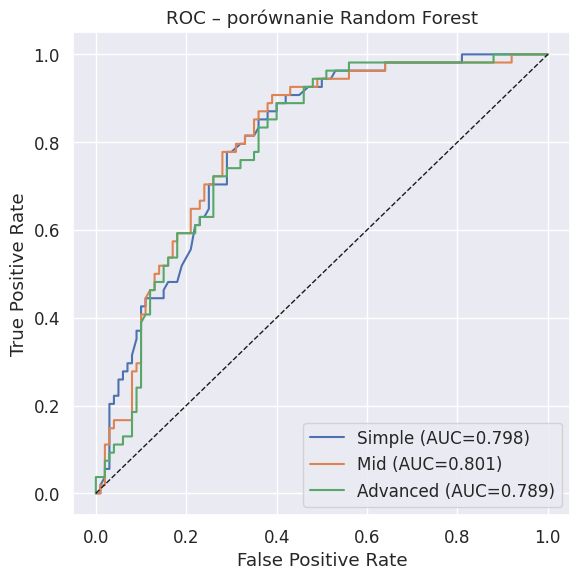

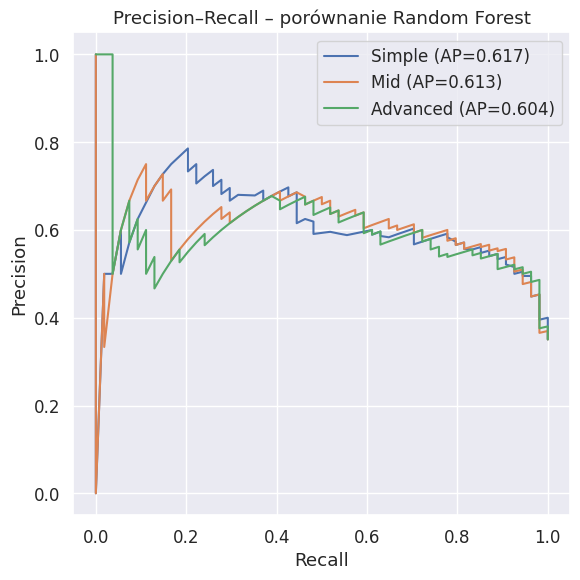

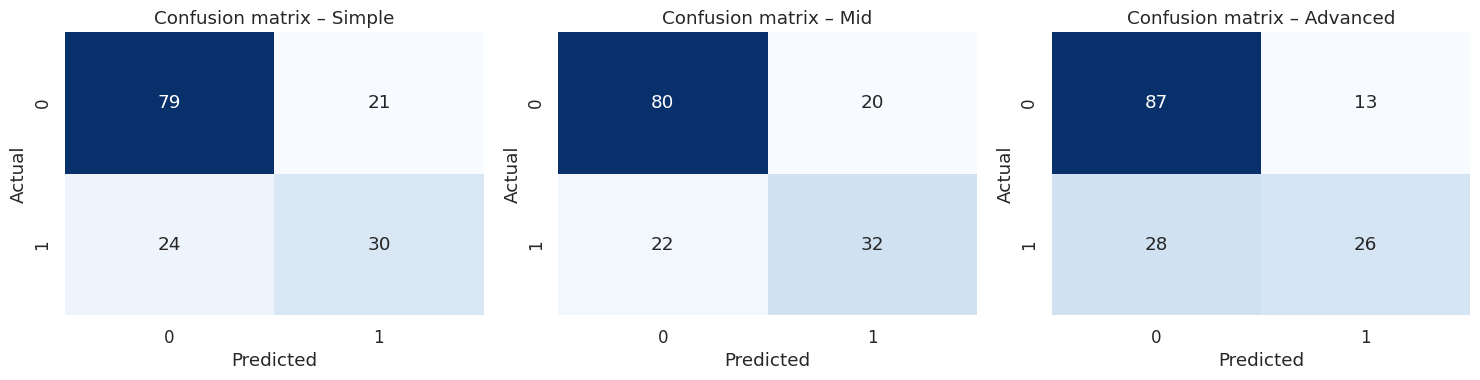

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog modeli
models = {
    "Simple":   joblib.load(models_dir / "rf_simple.joblib"),   # ładowanie modelu prostego
    "Mid":      joblib.load(models_dir / "rf_mid.joblib"),      # ładowanie modelu umiarkowanego
    "Advanced": joblib.load(models_dir / "rf_advanced.joblib"), # ładowanie modelu zaawansowanego
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # walidacja krzyżowa

records = []  # lista wyników
curves  = {}  # słownik krzywych

for tag, model in models.items():  # iteracja po modelach
    cv_res = cross_validate(
        model,
        X_train_rf_proc,
        y_train,
        cv=cv,
        scoring={  # metryki CV
            "ROC_AUC": "roc_auc",
            "Accuracy": "accuracy",
            "BalAcc": "balanced_accuracy",
            "Precision": "precision",
            "Recall": "recall",
            "F1": "f1",
        },
        n_jobs=-1,
        return_train_score=False
    )

    y_proba = model.predict_proba(X_test_rf_proc)[:, 1]  # prawdopodobieństwa
    y_pred  = model.predict(X_test_rf_proc)               # predykcje

    rec = {
        "Model":        tag,                                   # nazwa modelu
        "CV_ROC_AUC":   cv_res["test_ROC_AUC"].mean(),         # średnie AUC CV
        "CV_Accuracy":  cv_res["test_Accuracy"].mean(),        # średnie Accuracy CV
        "CV_BalAcc":    cv_res["test_BalAcc"].mean(),          # średnie BalAcc CV
        "CV_Precision": cv_res["test_Precision"].mean(),       # średnie Precision CV
        "CV_Recall":    cv_res["test_Recall"].mean(),          # średnie Recall CV
        "CV_F1":        cv_res["test_F1"].mean(),              # średnie F1 CV
        "Test_Accuracy":      accuracy_score(y_test, y_pred),        # Accuracy testu
        "Test_BalAcc":        balanced_accuracy_score(y_test, y_pred),# BalAcc testu
        "Test_Precision":     precision_score(y_test, y_pred, zero_division=0), # Precision testu
        "Test_Recall":        recall_score(y_test, y_pred, zero_division=0),    # Recall testu
        "Test_F1":            f1_score(y_test, y_pred, zero_division=0),        # F1 testu
        "Test_ROC_AUC":       roc_auc_score(y_test, y_proba),  # AUC ROC testu
        "Test_PR_AUC":        average_precision_score(y_test, y_proba), # AUC PR testu
        "Test_MCC":           matthews_corrcoef(y_test, y_pred), # współczynnik MCC
    }
    records.append(rec)  # dodanie rekordu

    fpr, tpr, _ = roc_curve(y_test, y_proba)                     # punkty ROC
    prec, rec_, _ = precision_recall_curve(y_test, y_proba)     # punkty PR
    curves[tag] = {"fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec_}  # zapis krzywych

metrics_df = pd.DataFrame(records).set_index("Model").round(3)  # DataFrame wyników
display(metrics_df)  # wyświetlenie metryk

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu ROC
for tag, pts in curves.items():  # iteracja po krzywych
    auc = metrics_df.loc[tag, "Test_ROC_AUC"]  # wartość AUC
    plt.plot(pts["fpr"], pts["tpr"], label=f"{tag} (AUC={auc:.3f})")  # rysowanie linii
plt.plot([0, 1], [0, 1], "k--", lw=1)  # linia bazowa
plt.xlabel("False Positive Rate")  # oś X
plt.ylabel("True Positive Rate")  # oś Y
plt.title("ROC – porównanie Random Forest")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu Precision–Recall
for tag, pts in curves.items():  # iteracja po krzywych PR
    ap = metrics_df.loc[tag, "Test_PR_AUC"]  # wartość AP
    plt.plot(pts["rec"], pts["prec"], label=f"{tag} (AP={ap:.3f})")  # rysowanie linii
plt.xlabel("Recall")  # oś X
plt.ylabel("Precision")  # oś Y
plt.title("Precision–Recall – porównanie Random Forest")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

SHOW_CM = True  # flaga wyświetlania macierzy
if SHOW_CM:
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))  # siatka macierzy
    for ax, (tag, model) in zip(axes, models.items()):  # iteracja po modelach
        cm = confusion_matrix(y_test, model.predict(X_test_rf_proc))  # macierz pomyłek
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)  # wykres macierzy
        ax.set_title(f"Confusion matrix – {tag}")  # tytuł wykresu
        ax.set_xlabel("Predicted")  # oś X
        ax.set_ylabel("Actual")    # oś Y
    plt.tight_layout()  # dopasowanie układu
    plt.show()  # wyświetlenie macierzy
